In [1]:
%matplotlib inline
# Switch to ''%matplotlib ipympl' for interactive plots
import warnings
import imp
import pickle
import lmfit
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

# Styling
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [2]:
# Initialise wrapper and test datasets
wrapper_fpath = (r"..\mobius.py")
wr = imp.load_source('mobius', wrapper_fpath)
wr.initialize('..\..\Applications\SimplyC\SimplyC.dll')

# Calibration functions
calib_fpath = (r"..\mobius_calib_uncert_lmfit.py")
cu = imp.load_source('mobius_calib_uncert_lmfit', calib_fpath)

In [3]:
# Load dataset
dataset = wr.DataSet.setup_from_parameter_and_input_files('../../Applications/SimplyC/Storgama/params_Storgama_noGW.dat', 
                                                          '../../Applications/SimplyC/Storgama/inputs_Storgama.dat')

### Link observed and simulated datasets

In order to assess model performance, we need to be able to compare simulated values to observations. The code below links simulated data series (Q, DOC) to the relevant observed datasets (as defined in the Mobius `'dataset'` object).

**Note:** "Inlet" is a monitoring location in the catchment, which was used as an "index" when setting up the model. The `'comparisons'` list below contains two tuples, each mapping a simulated dataset in the model to an observed data series. 

**To do**

 * Add wrapper functionality to get a list of possible comparisons directly from the dataset object? 

In [4]:
# List of simulated and observed variables to investigate for Morsa
 comparisons = [('Reach flow (daily mean, cumecs)', ['Storgama'], 'Observed flow', []),
                ('Reach DOC concentration (volume weighted daily mean)', ['Storgama'], 'Observed DOC', []),          
               ]

## 4. Manual calibration

The original data files used to create this Mobius `'dataset'` include deafult values and plausible ranges for each model parameter. The code below lists these default values for all the `'double'` parameters defined in the model (these are the ones available for calibration).

In [5]:
# Get parameter values defined in 'dataset'
param_df = cu.get_double_parameters_as_dataframe(dataset)
param_df

,name,unit,index,min_value,initial_value,max_value
0,Latitude,°,(),-9.000000e+01,59.000,9.000000e+01
1,Initial snow depth as water equivalent,mm,(),0.000000e+00,250.000,5.000000e+04
2,Degree-day factor for snowmelt,mm/°C/day,(),0.000000e+00,2.000,5.000000e+00
3,Proportion of precipitation that contributes t...,dimensionless,(),0.000000e+00,0.270,1.000000e+00
4,PET multiplication factor,dimensionless,(),0.000000e+00,0.300,2.000000e+00
5,Soil field capacity,mm,(),0.000000e+00,50.000,1.000000e+03
6,Manning's coefficient,s/(m^1/3),(),1.200000e-02,0.040,1.000000e-01
7,Catchment area,km^2,"(Storgama,)",0.000000e+00,0.540,1.000000e+04
8,Reach length,m,"(Storgama,)",0.000000e+00,1500.000,1.000000e+07
9,Reach slope,m/m,"(Storgama,)",1.000000e-05,0.020,3.000000e+00


Note the `'index'` column in this dataframe, which specifies how each parameter varies within the model structure.

For this particular dataset, the default values in the `'initial_value'` column were informed by manual calibration using the Mobius [GUI application](https://github.com/NIVANorge/Mobius#building-incaview-compatible-exes). We can easily run the model with these values and assess the goodness-of-fit. The functions below produce one plot and one set of summary statistics for each dataset in `'comparisons'`.


Goodness of fit for Reach flow (daily mean, cumecs) [Storgama] vs Observed flow []:
Mean error (bias): -0.003279
Mean absolute error: 0.010679
Root mean square error: 0.022102
Nash-Sutcliffe coefficient: 0.535449
Number of observations: 13880


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [Storgama] vs Observed DOC []:
Mean error (bias): 6.614992
Mean absolute error: 6.618821
Root mean square error: 7.626435
Nash-Sutcliffe coefficient: -27.979986
Number of observations: 1411



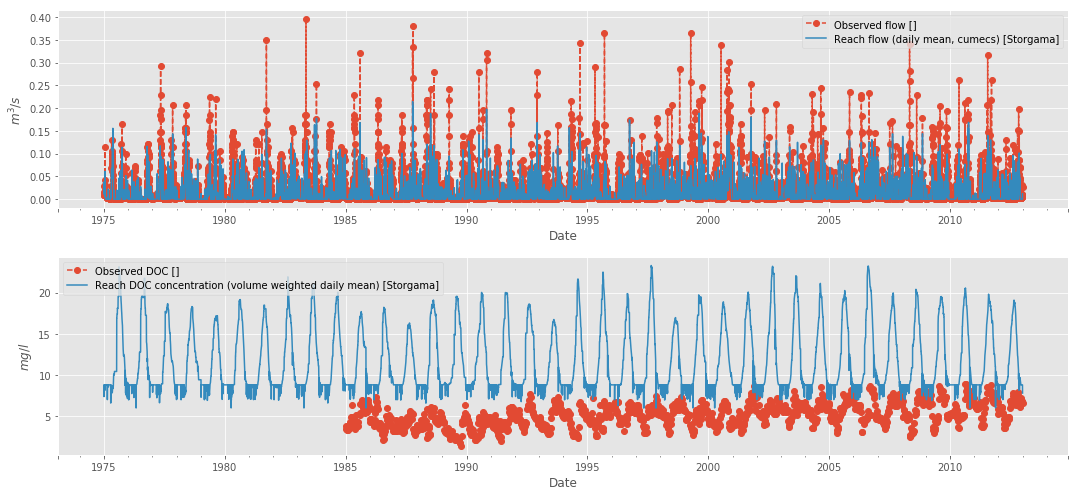

In [6]:
# Plot results from manual calibration
dataset.run_model()
cu.print_goodness_of_fit(dataset, comparisons)
cu.plot_objective(dataset, comparisons)

## 5. Auto-calibration

### 5.1. Choose parameters to calibrate

Parameter values should be informed by system knowledge wherever possible. In this example, we will choose to calibrate a sub-set of model parameters that are poorly constrained.

The code below selects **11 parameters** for further investigation.

**Note:** Several Pandas methods can be used to subset `'param_df'`. The approach illustrated below is simple, but rather rough and error-prone.  Consider using e.g. [`'df.query'`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) instead to explicitly select parameters by name and index.

In [7]:
# Get params to be calibrated
calib_df = param_df.loc[[2,3,4,5,6,11,13,15,16,17,18]].reset_index(drop=True)
#calib_df = param_df.loc[[2,3,4,5,6,11]].reset_index(drop=True)
calib_df

,name,unit,index,min_value,initial_value,max_value
0,Degree-day factor for snowmelt,mm/°C/day,(),0.000000e+00,2.000,5.000000e+00
1,Proportion of precipitation that contributes t...,dimensionless,(),0.000000e+00,0.270,1.000000e+00
2,PET multiplication factor,dimensionless,(),0.000000e+00,0.300,2.000000e+00
3,Soil field capacity,mm,(),0.000000e+00,50.000,1.000000e+03
4,Manning's coefficient,s/(m^1/3),(),1.200000e-02,0.040,1.000000e-01
5,Soil water time constant,days,"(All,)",1.000000e-02,2.200,4.000000e+01
6,Snow depth / soil temperature factor,/cm,(),-3.000000e+00,-0.001,-1.000000e-03
7,"Soil thermal conductivity (W/m/°C, range 0.4-0...",1E-6 m2/s,"(All,)",1.000000e-02,0.030,8.000000e-01
8,Gradient of the soil water [DOC] response to c...,1/degreesC,(),1.000000e-03,0.007,1.000000e+00
9,Coefficient describing intercept in [DOC]= m *...,dimensionless,(),-1.797693e+308,0.880,1.797693e+308


In order to easily refer to model parameters in the subsequent code, and to facilitate creation of tidy plots, it is useful to have abbreviated parameter names. These are defined below.

**Note:** Short names for model parameters **must not** begin with `'err_'`

**To do**: Require the user to define a `'short_name'` for each parameter in the original dataset file. These names are useful and defining them here is messy.

In [8]:
# Add 'short_name' column for calibrating parameters
calib_df['short_name'] = ['DDFmelt',
                           'fquick',
                           'alphaPET',
                           'FC',
                           'a_Q',
                           'Ts',
                           'Tsoil_snowk',
                           'Soil_K',
                           'm_DOCsoilT',
                           'c_DOCsoilT',
                           'DOC_bsl',
                           ]

#calib_df['short_name'] = ['DDFmelt',
#                          'fquick',
#                          'alphaPET',
#                          'FC',
#                          'a_Q',
#                          'Ts']

Having defined a dataframe of parameters we wish to calibrate, complete with short names, initial values and minimum to maximum ranges, we can instantiate an [LMFit Parameters](https://lmfit.github.io/lmfit-py/parameters.html) object, which makes it easy to keep track of bounded parameter values. 

In [9]:
# Convert to LMFit parameter object
params = cu.parameter_df_to_lmfit(calib_df)

It is easy to modify the prior ranges for each parameter, as illustrated in the code below. Initial values can also be changed using e.g. `'params['DDFmelt'].value = 2.5'`, or calibration can be disabled entirely for specific parameters using e.g. `'params['DDFmelt'].vary = False'`. Note that parameters must be referred to by their `'short_name'` attribute.

In [10]:
# Optionally refine prior ranges
params['DDFmelt'].min = 0.05
params['DDFmelt'].max = 4

params['fquick'].min = 0.002
params['fquick'].max = 0.2

params['alphaPET'].min = 0.05
params['alphaPET'].max = 1

params['FC'].min = 1
params['FC'].max = 1000 #500

params['a_Q'].min = 0.002
params['a_Q'].max = 0.8

params['Ts'].min = 0.5
params['Ts'].max = 50 #15

params['c_DOCsoilT'].min = 0.
params['c_DOCsoilT'].max = 2.0

# params['Tsoil_snowk'].min = 
# params['Tsoil_snowk'].max = 

# params['Soil_K'].min = 
# params['Soil_K'].max = 

# params['m_DOCsoilT'].min =
# params['m_DOCsoilT'].max =

# params['DOC_bsl'].min =
# params['DOC_bsl'].max =

The `'pretty_print'` statement provides a convenient summary of the calibrating parameters and prior ranges we have specified so far.

In [11]:
#params['alphaPET'].value = 0.6

params.pretty_print(columns=['value', 'min', 'max', 'vary'])

Name            Value      Min      Max     Vary
DDFmelt             2     0.05        4     True
DOC_bsl            10        0       70     True
FC                 50        1     1000     True
Soil_K           0.03     0.01      0.8     True
Ts                2.2      0.5       50     True
Tsoil_snowk    -0.001       -3   -0.001     True
a_Q              0.04    0.002      0.8     True
alphaPET          0.3     0.05        1     True
c_DOCsoilT       0.88        0        2     True
fquick            0.2    0.002      0.2     True
m_DOCsoilT      0.007    0.001        1     True


### 5.2. Least squares optimisation

LMFit provides a convenient API to several Python optimisers (see [here](https://lmfit.github.io/lmfit-py/fitting.html#the-minimize-function) for details). 

Some of these optimisers also provide confidence intervals and correlations for the "best" parameters. These are approximate, but they provide useful information about the model and may help you to refine parameter ranges (or even the model structure) before undertaking a more comprehensive calibration exercise using MCMC (see below).

All of these optimisers aim to minimise the sum of squared residuals. From a "formal" statistical point of view, this is equivalent to assuming a likelihood function with independent and identically distributed (i.i.d.) Gaussian errors, which may not be the best choice. Nevertheless, minimising the sum of squared errors is often a good starting point, especially given the range of optimisers available.

**Note:** Performance can vary dramatically between optimisers, so it's often a good idea to try a few different alternatives. This will also allow you to check whether the same "optimum" is identified by the various algorithms.

In [12]:
%%time
# Minimise using Levenberg–Marquardt (gives similar output to Nelder-Mead, 
# but in this case it's faster)
mi, res = cu.minimize_residuals(params, dataset, comparisons, method='nelder', norm=False, 
                                skip_timesteps=365)

print('Optimisation results:\n')
lmfit.report_fit(res)
print('\n\nOptimised parameter values:\n')
res.params.pretty_print(precision=3)

Optimisation results:

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 706
    # data points      = 14926
    # variables        = 11
    chi-square         = 2257.61843
    reduced chi-square = 0.15136563
    Akaike info crit   = -28170.1421
    Bayesian info crit = -28086.4226
##  Warning: uncertainties could not be estimated:
    Soil_K:       at boundary
[[Variables]]
    DDFmelt:      1.99747093 +/-        nan (nan%) (init = 2)
    fquick:       0.19805494 +/-        nan (nan%) (init = 0.2)
    alphaPET:     0.33064524 +/- 0.04400846 (13.31%) (init = 0.3)
    FC:           119.047256 +/- 27.4186322 (23.03%) (init = 50)
    a_Q:          0.02180654 +/- 0.02795307 (128.19%) (init = 0.04)
    Ts:           5.15253640 +/- 0.46816383 (9.09%) (init = 2.2)
    Tsoil_snowk: -0.00100043 +/- 1.9633e-05 (1.96%) (init = -0.001)
    Soil_K:       0.01000000 +/- 3.9445e-07 (0.00%) (init = 0.03)
    m_DOCsoilT:   0.00498468 +/-        nan (nan%) (init = 0.007)
  

The optimiser has run the model 316 times in around 45 seconds, which is much faster than the original pure Python implementation of SimplyP. 

Output includes estimated parameter correlations and confidence intervals: note, for example, the `'Stderr'` column that has been added to the parameters table immediately above.

### 5.3. Visualise results

To see the model output for the optimised parameter values, first use `'set_parameter_values'` to update the default values, and then re-run the model, as above.


Goodness of fit for Reach flow (daily mean, cumecs) [Storgama] vs Observed flow []:
Mean error (bias): -0.003574
Mean absolute error: 0.010184
Root mean square error: 0.022869
Nash-Sutcliffe coefficient: 0.502654
Number of observations: 13880


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [Storgama] vs Observed DOC []:
Mean error (bias): -0.093676
Mean absolute error: 1.005765
Root mean square error: 1.266945
Nash-Sutcliffe coefficient: 0.200220
Number of observations: 1411



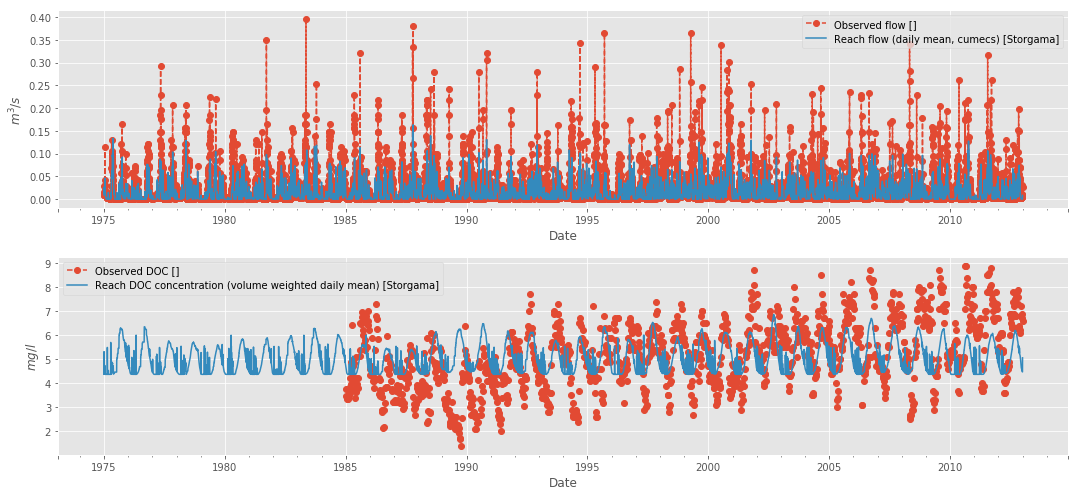

In [14]:
# Plot results from optimisation
cu.set_parameter_values(res.params, dataset)
dataset.run_model()
cu.print_goodness_of_fit(dataset, comparisons)
cu.plot_objective(dataset, comparisons)
dataset.write_parameters_to_file('optimal_parameters.dat')

## 6. Full calibration and uncertainty analysis using MCMC

Bayesian MCMC provides much more comprehensive information regarding model performance, but it's also more complicated and computationally intensive. Although it's perfectly possible to begin your model analysis with MCMC, it's usually a good idea to experiment with the optimisation options described above first, and then apply MCMc as a second step.

### 6.1. Likelihood function

The (log) likelihood function describes the probability that the model, when run with a given set of parameters, will reproduce the observed data. Formulating an appropriate likelihood function is both important and challenging, and there's a lot of literature on the subject. In this example, we'll assume **heteroscedastic**, independent Gaussian errors, which is one step better than the simplest/commonest i.i.d. approach. If you'd like to know more about where this approach comes from, see [here](http://jamessample.github.io/enviro_mod_notes/) (especially [section 2 of notebook 6](https://nbviewer.jupyter.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/06_Beyond_Metropolis.ipynb#2.-Choosing-a-likelihood-function)).

In order to run parallelised MCMC, you need to create a separate Python file similar to `'simplyp_calib_uncert.py'`. This file defines your log likelihood function and provides the Mobius `'dataset'` as a "top-level object", which makes it amenable to parallel processing.

**To do**

 * See if we can figure out parallelisation from within Jupyter?

### 6.2. Error terms

Using a formal statistical likelihood involves estimating some additional error terms. We'll assume that the error distribution for all three phosphorus species is the same, so we need three terms in total (for Q, SS and P). These can be added to the result obtained from the optimiser in section 5, above.

**Note:** Names for error terms **must** begin with `'err_'`. Conversely, short names for model parameters **must not** begin with `'err_'`.

In [14]:
# Add error params
#mi.params.add('err_q', value=0.5, min=0.05, max=3)
#mi.params.add('err_ss', value=0.5, min=0.05, max=5)
#mi.params.add('err_p', value=0.5, min=0.05, max=2)

params.add('err_q', value=0.5, min=0.05, max=10)
params.add('err_c', value=0.5, min=0.05, max=10)

#mi.params.pretty_print(columns=['value', 'min', 'max', 'vary'])
params.pretty_print(columns=['value', 'min', 'max', 'vary'])

Name         Value      Min      Max     Vary
DDFmelt          2        0        4     True
FC             100        1     1000     True
Ts               4      0.5       50     True
a_Q            0.4        0      0.8     True
alphaPET       0.6        0        1     True
err_c          0.5     0.05       10     True
err_q          0.5     0.05       10     True
fquick         0.1    0.002      0.2     True


We also need to define a dictionary matching each of the observed data series in `'comparisons'` to the appropriate error term.

In [15]:
# Link error params to model datasets
#error_param_dict = {'Observed Q':          'err_q',
#                    'Observed SS at Kure': 'err_ss',
#                    'Observed TP at Kure': 'err_p',
#                    'Observed TDP at Kure':'err_p',
#                    'Observed PP at Kure': 'err_p',
#                   }

error_param_dict = {'Discharge': 'err_q',
                    'DOC':       'err_c',
                   }

**Note:** LMFit parameter objects provide additional features for linking and combining parameters using the `'expr'` argument - see [here](https://lmfit.github.io/lmfit-py/constraints.html) for further details. The error terms for TDP and PP could equally well have been defined as follows:

    # Add error params
    mi.params.add('err_q', value=0.5, min=0.05, max=3)
    mi.params.add('err_ss', value=0.5, min=0.05, max=5)
    mi.params.add('err_tp', value=0.5, min=0.05, max=2)
    mi.params.add('err_tdp', expr='err_tp')             # Use a single error term for all P types
    mi.params.add('err_pp', expr='err_tp')              # Use a single error term for all P types 
    
Although not necessary here, this kind of syntax is especially useful when dealing with parameters representing proportions, where the total need to be constant.

### 6.3. MCMC options

In order to run the MCMC in parallel, all the settings from above are added to a dictionary and "pickled". Some additional options are specified below.

**To do**

 * Currently, the dataset paths need to be hard-coded in `'simplyp_calib_uncert.py'`. It would be nice to figure out how to pass these in "dynamically", without breaking the parallelisation

In [16]:
# emcee setup
nworkers = 8    # Number of cores/processes for parallelisation
ntemps = 1      # Number of temperatures for parallel tempering (use 1 for default ensemble sampler)
nsteps = 2000   # Number of steps per chain
nwalk = 100     # Number of chains/walkers
nburn = 1000     # Number of steps to discard as burn-in
thin = 1        # Keep only every 'thin' steps to reduce chain auto-correlation

# Chain initialisation
# 'uniform' => Chain starting locations sampled uniformly from prior
# 'optimum' => Chain starting locations sampled from a small Gaussian ball in vicinity of optimum
init_chains = 'uniform'  # Or 'optimum'. 

skip_timesteps = 30  # Number of time steps to skip before calulating fit

# Result file paths
result_path = r'pickled\\mcmc_results.pkl'
chain_plot_path = r'simplyc_plots\chains.png'
corner_plot_path = r'simplyc_plots\corner.png'

In [17]:
# Save settings for passing to MCMC
settings_dict = {'params':params,
                 'error_param_dict':error_param_dict,
                 'comparisons':comparisons,
                 'skip_timesteps':skip_timesteps,
                 'nworkers':nworkers,
                 'ntemps':ntemps,
                 'nsteps':nsteps,
                 'nwalk':nwalk,
                 'nburn':nburn,
                 'thin':thin,
                 'init_chains':init_chains,
                 'result_path':result_path,
                 'chain_path':chain_plot_path,
                 'corner_path':corner_plot_path,                 
                }

with open('pickled\\mcmc_settings.pkl', 'wb') as handle:
    pickle.dump(settings_dict, handle)

### 6.4. Run MCMC

Time elapsed running emcee: 98.84 minutes.



Quantiles:
[(0.025, 2.3547295985791754), (0.5, 3.5613251974326694), (0.975, 3.7233092037245439)]
Quantiles:
[(0.025, 0.12964102016377299), (0.5, 0.19994371529744664), (0.975, 0.19999829161159505)]
Quantiles:
[(0.025, 0.4897285471517217), (0.5, 0.4993457619766532), (0.975, 0.84791748526718358)]


Quantiles:
[(0.025, 1.1002763360239625), (0.5, 3.364522470246829), (0.975, 239.06777742897805)]
Quantiles:
[(0.025, 0.00028235933470479571), (0.5, 0.00029202163916394795), (0.975, 0.00030363661789918844)]


Quantiles:
[(0.025, 0.61683713145660801), (0.5, 49.86785802394391), (0.975, 49.995705466800793)]


Quantiles:
[(0.025, 1.3229860020737352), (0.5, 1.3476281895551825), (0.975, 8.7213163530879072)]


Quantiles:
[(0.025, 2.7564935076744006), (0.5, 2.9590150607261236), (0.975, 5.0728812219935815)]



Best sample (max log likelihood):

Goodness of fit for Reach flow (daily mean, cumecs) [Inlet] vs Discharge []:
Mean error (bias): 0.000239
Mean absolute error: 0.012551
Mean square error: 0.000565
Nash-Sutcliffe coefficient: 0.385496
Number of observations: 9832


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [Inlet] vs DOC []:
Mean error (bias): 0.530469
Mean absolute error: 2.324681
Mean square error: 8.833783
Nash-Sutcliffe coefficient: 0.128936
Number of observations: 1027



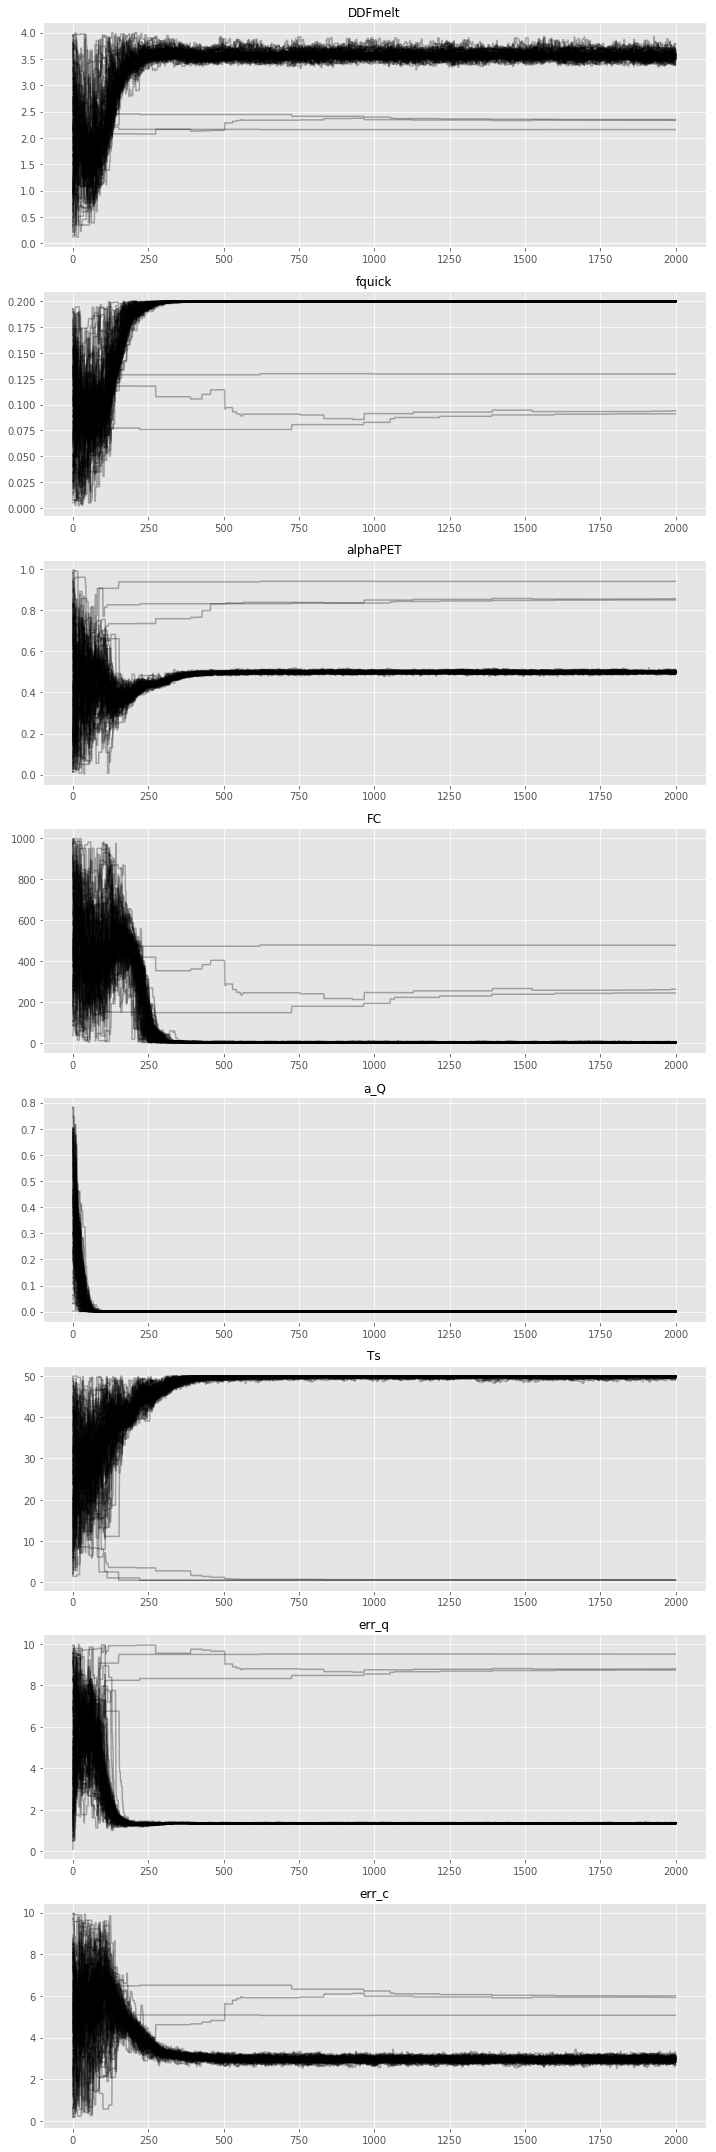

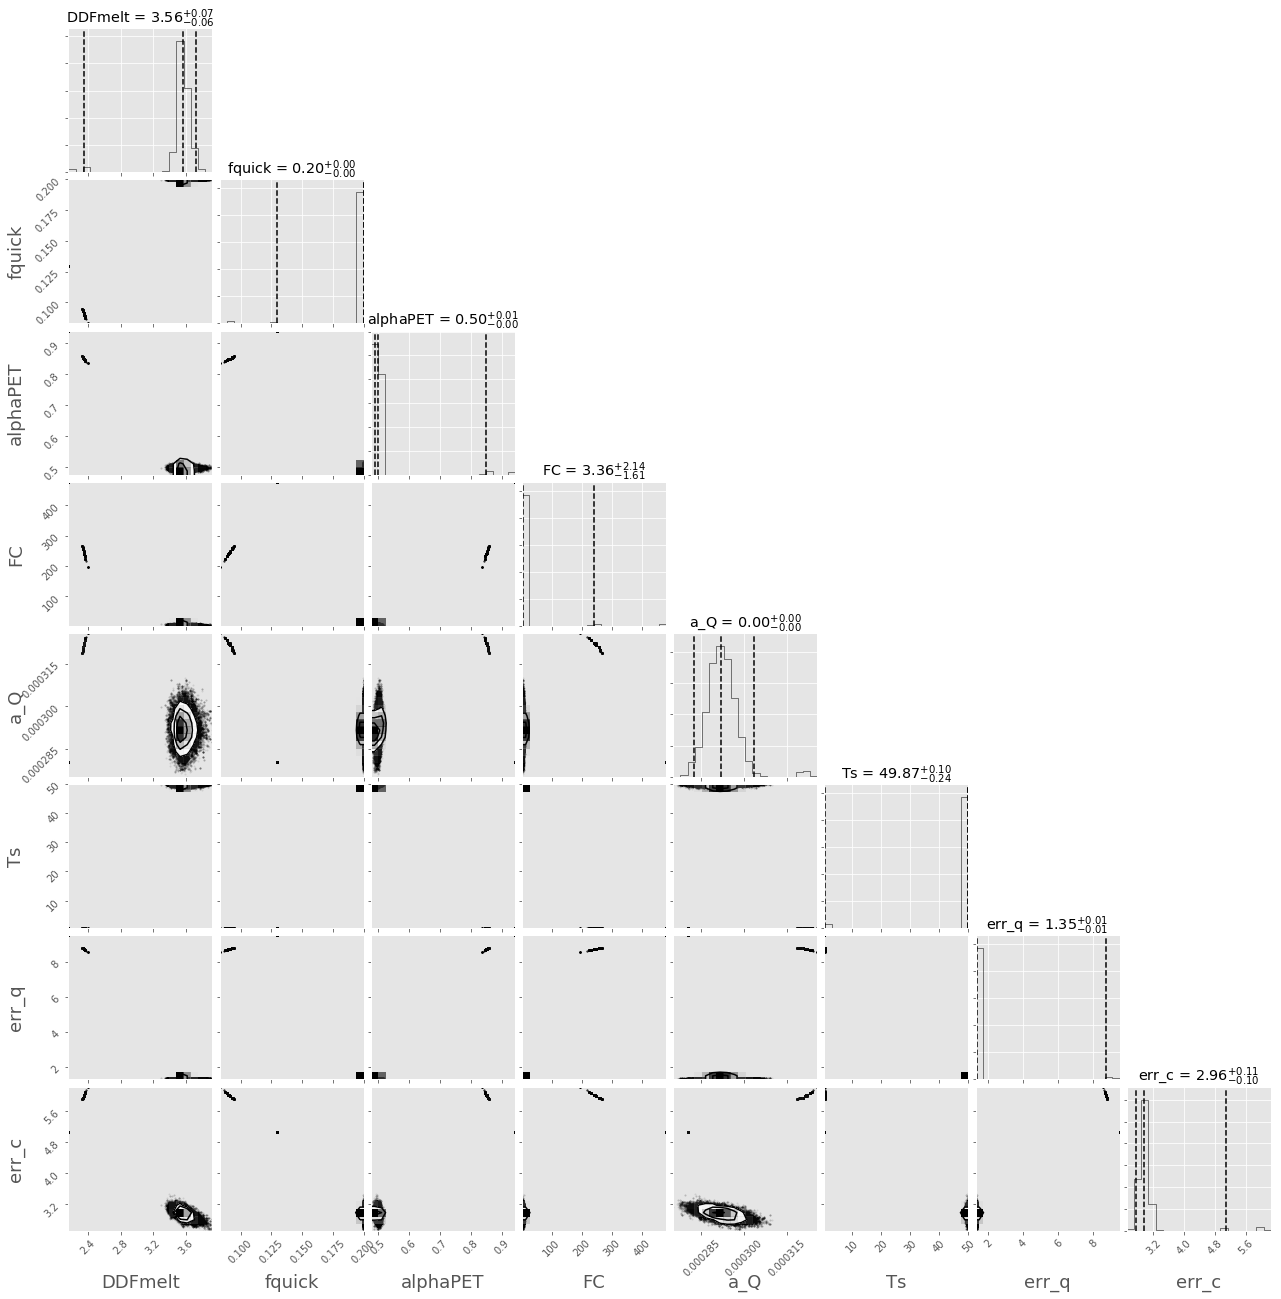

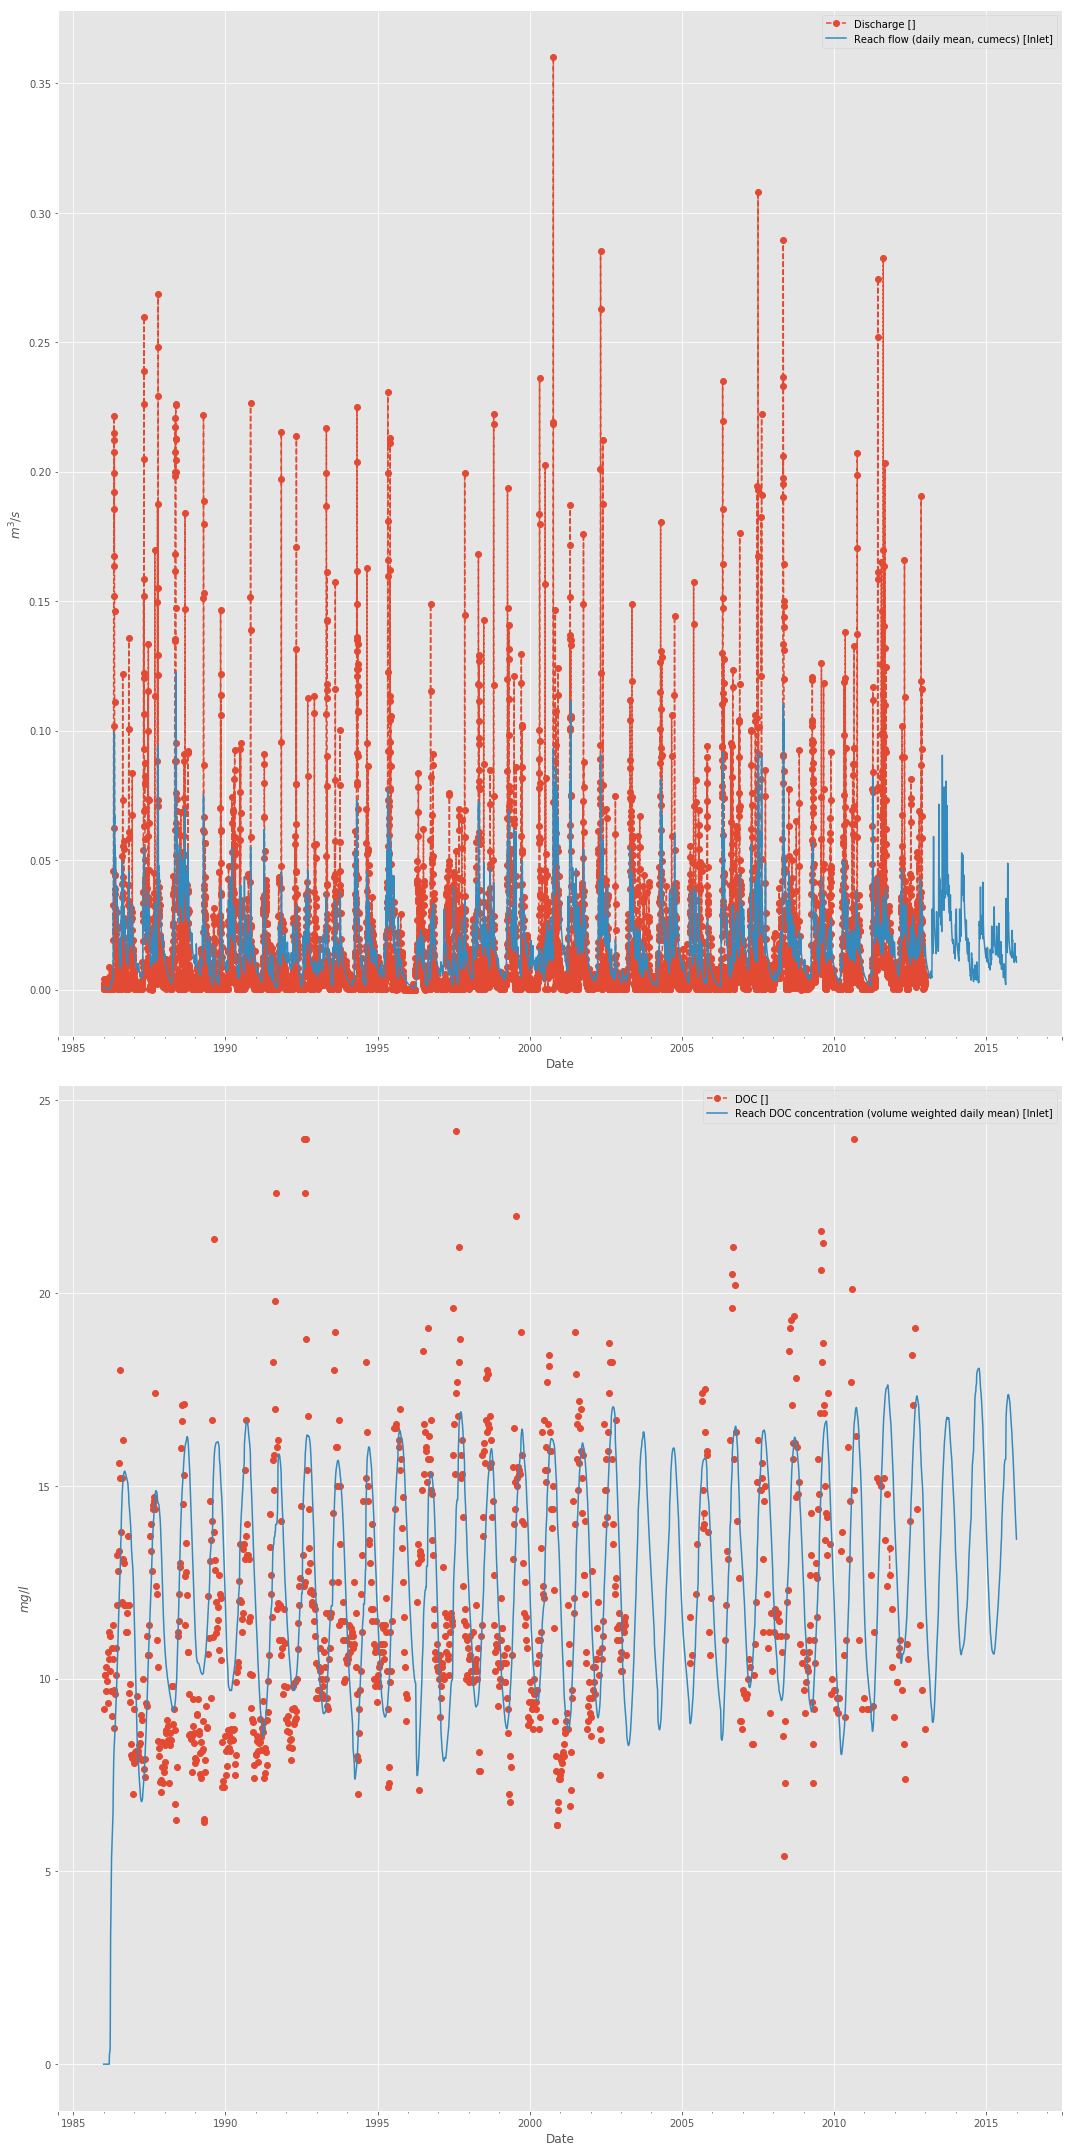

In [18]:
%run -i simplyc_calib_uncert.py

### 6.5. Parameter and predictive uncertainty

**To do**

 * Add function to `'mobius_calib_uncert_lmfit.py'` to sample from posterior and create time series showing parameter and predictive uncertainty